# Data Preparation
Import the data you need and perform necessary transformation

In [2]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

# Load your data
df = pd.read_csv("ohlcv.csv")

# Step 1: Drop rows with missing timestamps and sort by datetime
df.dropna(subset=["start_time"], inplace=True)
df.sort_values(by="datetime", inplace=True)
df.set_index("datetime", inplace=True)

In [3]:
df

start_time     close      high       low      open  \
datetime                                                                     
2024-01-01 00:00:00  1704067200000  42475.23  42554.57  42261.02  42283.58   
2024-01-01 01:00:00  1704070800000  42613.56  42775.00  42431.65  42475.23   
2024-01-01 02:00:00  1704074400000  42581.10  42638.41  42500.00  42613.57   
2024-01-01 03:00:00  1704078000000  42330.49  42586.64  42230.08  42581.09   
2024-01-01 04:00:00  1704081600000  42399.99  42399.99  42209.46  42330.50   
...                            ...       ...       ...       ...       ...   
2024-12-31 19:00:00  1735671600000  94166.88  94290.91  93712.45  93875.69   
2024-12-31 20:00:00  1735675200000  93564.04  94222.50  93450.17  94166.88   
2024-12-31 21:00:00  1735678800000  93899.68  93964.15  93504.67  93564.01   
2024-12-31 22:00:00  1735682400000  93488.84  93899.67  93375.58  93899.67   
2024-12-31 23:00:00  1735686000000  93576.00  93756.00  93375.38  93488.83   

                         volume  
datetime                         
2024-01-01 00:00:00  1271.68108  
2024-01-01 01:00:00  1196.37856  
2024-01-01 02:00:00   685.21980  
2024-01-01 03:00:00   794.80391  
2024-01-01 04:00:00   715.41760  
...                         ...  
2024-12-31 19:00:00   462.79342  
2024-12-31 20:00:00   733.04147  
2024-12-31 21:00:00   337.52715  
2024-12-31 22:00:00   315.53272  
2024-12-31 23:00:00   336.57995  

[8784 rows x 6 columns]

# Feature Engineering
Create features based on your need.

In [5]:
# Step 2: Create features (assuming 1-hour data and 4-hour window)
window = 4 # in hours
derived_features = ["log_return", "volatility", "momentum", "zscore"]

df["log_return"] = np.log(df["close"] / df["close"].shift(1))
df["volatility"] = df["log_return"].rolling(window).std()
df["momentum"] = df["close"] / df["close"].shift(window) - 1
df["zscore"] = (df["close"] - df["close"].rolling(window).mean()) / df["close"].rolling(window).std()

# Step 3: Keep only relevant columns
df = df[["close"] + derived_features].dropna()

In [6]:
df

close  log_return  volatility  momentum    zscore
datetime                                                                 
2024-01-01 04:00:00  42399.99    0.001640    0.003996 -0.001771 -0.590773
2024-01-01 05:00:00  42234.01   -0.003922    0.003341 -0.008907 -1.039746
2024-01-01 06:00:00  42396.69    0.003844    0.004582 -0.004331  0.725311
2024-01-01 07:00:00  42492.46    0.002256    0.003381  0.003826  1.039305
2024-01-01 08:00:00  42549.99    0.001353    0.003365  0.003538  0.953201
...                       ...         ...         ...       ...       ...
2024-12-31 19:00:00  94166.88    0.003097    0.004778 -0.013050 -0.213567
2024-12-31 20:00:00  93564.04   -0.006422    0.004909 -0.013749 -1.330139
2024-12-31 21:00:00  93899.68    0.003581    0.004799 -0.002351  0.093700
2024-12-31 22:00:00  93488.84   -0.004385    0.005119 -0.004121 -0.927405
2024-12-31 23:00:00  93576.00    0.000932    0.004628 -0.006275 -0.307642

[8780 rows x 5 columns]

# Train the model

In [8]:
# Step 4: Prepare input features and scale them
features = df[derived_features]
scaler = StandardScaler()
X = scaler.fit_transform(features)

# Step 5: Fit HMM
from hmmlearn.hmm import GaussianHMM
model = GaussianHMM(n_components=4, covariance_type="full", n_iter=100, random_state=42)
model.fit(X)

GaussianHMM(covariance_type='full', n_components=4, n_iter=100, random_state=42)

In [9]:
# Step 6: Predict regimes
regimes = model.predict(X)

# Step 7: Append regime back to a new DataFrame with original data
df_regime = df.copy()
df_regime["regime"] = regimes

# Check result
print("\nRegime counts:")
df_regime["regime"].value_counts()



Regime counts:


regime
2    3120
0    2348
3    2045
1    1267
Name: count, dtype: int64

In [10]:
df_regime.groupby("regime")[["log_return", "volatility", "momentum", "zscore"]].mean()

log_return  volatility  momentum    zscore
regime                                            
0        -0.000991    0.002172 -0.002166 -0.664188
1         0.000087    0.010796  0.000163  0.024221
2        -0.000085    0.005087  0.000144 -0.033889
3         0.001602    0.002352  0.003972  0.974746

In [11]:
regime_labels = {
    0: "bearish",
    1: "volatile",
    2: "sideways",
    3: "bullish"
}
df_regime["regime_label"] = df_regime["regime"].map(regime_labels)
df_regime

close  log_return  volatility  momentum    zscore  \
datetime                                                                    
2024-01-01 04:00:00  42399.99    0.001640    0.003996 -0.001771 -0.590773   
2024-01-01 05:00:00  42234.01   -0.003922    0.003341 -0.008907 -1.039746   
2024-01-01 06:00:00  42396.69    0.003844    0.004582 -0.004331  0.725311   
2024-01-01 07:00:00  42492.46    0.002256    0.003381  0.003826  1.039305   
2024-01-01 08:00:00  42549.99    0.001353    0.003365  0.003538  0.953201   
...                       ...         ...         ...       ...       ...   
2024-12-31 19:00:00  94166.88    0.003097    0.004778 -0.013050 -0.213567   
2024-12-31 20:00:00  93564.04   -0.006422    0.004909 -0.013749 -1.330139   
2024-12-31 21:00:00  93899.68    0.003581    0.004799 -0.002351  0.093700   
2024-12-31 22:00:00  93488.84   -0.004385    0.005119 -0.004121 -0.927405   
2024-12-31 23:00:00  93576.00    0.000932    0.004628 -0.006275 -0.307642   

                     regime regime_label  
datetime                                  
2024-01-01 04:00:00       2     sideways  
2024-01-01 05:00:00       2     sideways  
2024-01-01 06:00:00       2     sideways  
2024-01-01 07:00:00       3      bullish  
2024-01-01 08:00:00       3      bullish  
...                     ...          ...  
2024-12-31 19:00:00       2     sideways  
2024-12-31 20:00:00       2     sideways  
2024-12-31 21:00:00       2     sideways  
2024-12-31 22:00:00       2     sideways  
2024-12-31 23:00:00       2     sideways  

[8780 rows x 7 columns]

In [12]:
# Get the soft state membership probabilities
posterior_probs = model.predict_proba(X)  # shape: (n_samples, n_components)

# Create column names for each state
proba_columns = [f"prob_state_{i}" for i in range(model.n_components)]

# Create a DataFrame from the probabilities
posterior_df = pd.DataFrame(posterior_probs, columns=proba_columns, index=df_regime.index)

# Concatenate with your original df_regime
df_regime = pd.concat([df_regime, posterior_df], axis=1)

# Show the result
df_regime.head()

close  log_return  volatility  momentum    zscore  \
datetime                                                                    
2024-01-01 04:00:00  42399.99    0.001640    0.003996 -0.001771 -0.590773   
2024-01-01 05:00:00  42234.01   -0.003922    0.003341 -0.008907 -1.039746   
2024-01-01 06:00:00  42396.69    0.003844    0.004582 -0.004331  0.725311   
2024-01-01 07:00:00  42492.46    0.002256    0.003381  0.003826  1.039305   
2024-01-01 08:00:00  42549.99    0.001353    0.003365  0.003538  0.953201   

                     regime regime_label   prob_state_0   prob_state_1  \
datetime                                                                 
2024-01-01 04:00:00       2     sideways  1.474824e-117  1.078900e-221   
2024-01-01 05:00:00       2     sideways   8.571254e-03   1.850885e-04   
2024-01-01 06:00:00       2     sideways   2.725973e-03   4.354643e-04   
2024-01-01 07:00:00       3      bullish   3.040385e-03   4.513682e-06   
2024-01-01 08:00:00       3      bullish   2.150190e-03   2.999192e-07   

                     prob_state_2  prob_state_3  
datetime                                         
2024-01-01 04:00:00      1.000000  0.000000e+00  
2024-01-01 05:00:00      0.991244  6.387617e-12  
2024-01-01 06:00:00      0.987565  9.273222e-03  
2024-01-01 07:00:00      0.013828  9.831272e-01  
2024-01-01 08:00:00      0.000511  9.973380e-01

# Creating Pipeline

In [49]:
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np

class Strategy(ABC):
    @abstractmethod
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        pass


class HMMRegimeStrategy(Strategy):
    def __init__(self, model, regime_labels: dict):
        self.model = model
        self.regime_labels = regime_labels

    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        features = data[["log_return", "volatility", "momentum", "zscore"]]
        scaler = StandardScaler()
        X = scaler.fit_transform(features)
        
        posterior_probs = self.model.predict_proba(X)
        regimes = self.model.predict(X)
    
        n = len(data)
        signals = np.zeros(n, dtype=int)
        label_to_id = {v: k for k, v in self.regime_labels.items()}
        
    
        for i in range(n):
            current = regimes[i]
            current_label = self.regime_labels[current]
            state_probs = posterior_probs[i]
    
            if current_label == "bullish" and (
                state_probs[label_to_id.get("bullish", -1)] > 0.6 or
                state_probs[label_to_id.get("volatile", -1)] > 0.7):
                signals[i] = 1  # long
            
    
            elif current_label == "bearish" and (
                state_probs[label_to_id.get("bearish", -1)] > 0.6 or
                state_probs[label_to_id.get("sideways", -1)] > 0.7):
                signals[i] = -1  # short
    
        return pd.Series(signals, index=data.index)

In [55]:
import pandas as pd
from collections import deque

class SmartHMMStrategy(HMMRegimeStrategy):
    def __init__(self, model, regime_labels, debounce=3, trans_thresh=0.5):
        super().__init__(model, regime_labels)
        self.debounce = debounce
        self.trans_thresh = trans_thresh

    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        features = data[["log_return","volatility","momentum","zscore"]]
        X = StandardScaler().fit_transform(features)
        post = self.model.predict_proba(X)
        trans = self.model.transmat_
        window = deque(maxlen=self.debounce)
        signals = []
        for i in range(len(data)):
            window.append(post[i])
            avg_prob = sum(window) / len(window)
            curr_state = np.argmax(avg_prob)
            next_prob = trans[curr_state].max()
            # require both smoothed posterior AND transition strength
            if avg_prob[curr_state] > 0.6 and next_prob > self.trans_thresh:
                signals.append(1 if self.regime_labels[curr_state]=="bullish" else -1)
            else:
                signals.append(0)
        return pd.Series(signals, index=data.index)

In [45]:
from typing import Union, Optional, Dict
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

class Backtester:
    def __init__(
        self,
        data: Union[pd.DataFrame, pd.Series],
        positions: Optional[pd.Series] = None,
        trade_fee: float = 0.0005
    ):
        # Normalize input:
        if isinstance(data, pd.Series):
            # Single series of close prices
            self.data = pd.DataFrame({'close': data})
            if positions is None:
                raise ValueError("Positions series must be provided when passing a Series of close prices.")
            self.data['positions'] = positions
        else:
            # Full DataFrame
            self.data = data.copy()
            if positions is not None:
                self.data['positions'] = positions
            elif 'positions' not in self.data:
                raise ValueError("Positions must be in the DataFrame or passed explicitly.")

        self.trade_fee = trade_fee

    def run(self) -> pd.DataFrame:
        df = self.data.copy()
        # 1) Price change
        df['price_change'] = df['close'].pct_change().fillna(0)
        # 2) Previous position and trades
        df['prev_pos'] = df['positions'].shift(1).fillna(0)
        df['trades'] = (df['positions'] - df['prev_pos']).abs()
        # 3) Raw PnL
        df['pnl_raw'] = df['prev_pos'] * df['price_change']
        # 4) Trade cost
        df['trade_cost'] = df['trades'] * self.trade_fee
        # 5) Net PnL
        df['pnl'] = df['pnl_raw'] - df['trade_cost']
        # 6) Equity curve
        df['equity'] = df['pnl'].cumsum()
        # 7) Rolling max drawdown
        rolling_max = df['equity'].shift(1).expanding().max()
        df['max_dd'] = df['equity'] - rolling_max
        df.loc[df.index[0], 'max_dd'] = 0
        # 8) Metrics
        sharpe = df['pnl'].mean() / df['pnl'].std() if df['pnl'].std() > 0 else 0.0
        max_dd_value = df['max_dd'].min()
        trade_freq_pct = df['trades'].sum() / len(df) * 100
        print(f"Sharpe Ratio        : {sharpe:.4f}")
        print(f"Max Drawdown (%)    : {max_dd_value * 100:.4f}")
        print(f"Trade Frequency (%) : {trade_freq_pct:.2f}")

        self._plot_close_equity_graph(df)
        self._plot_close_maxdd_graph(df)
        self._plot_close_equity_maxdd_graph(df)

        return df[['close', 'positions', 'trades', 'pnl', 'equity', 'max_dd']]

    def _plot_close_equity_graph(self, df: pd.DataFrame):
        x = df.index
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=df['close'],  name='Close'))
        fig.add_trace(go.Scatter(x=x, y=df['equity'], name='Equity', yaxis='y2'))

        fig.update_layout(
            title='Close vs. Equity',
            xaxis_title='Date',
            yaxis=dict(title='Close Price'),
            yaxis2=dict(title='Equity',
                        overlaying='y', side='right'),
            legend=dict(x=0.02, y=0.98),
            width=900, height=500
        )

        fig.show()

    def _plot_close_maxdd_graph(self, df: pd.DataFrame):
        x = df.index

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=df['close'],    name='Close'))
        fig.add_trace(go.Scatter(x=x, y=df['max_dd'],   name='Max Drawdown', yaxis='y2'))
        
        fig.update_layout(
            title='Close vs. Max Drawdown',
            xaxis_title='Date',
            yaxis=dict(title='Close Price'),
            yaxis2=dict(title='Drawdown',
                        overlaying='y', side='right'),
            legend=dict(x=0.02, y=0.98),
            width=900, height=500
        )
        
        fig.show()

    def _plot_close_equity_maxdd_graph(self, df: pd.DataFrame):
        x = df.index
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=df['close'],      name='Close'))
        fig.add_trace(go.Scatter(x=x, y=df['equity'],     name='Equity',       yaxis='y2'))
        fig.add_trace(go.Scatter(x=x, y=df['max_dd'],     name='Max Drawdown', yaxis='y2',
                                  line=dict(dash='dash')))
        
        fig.update_layout(
            title='Close vs Equity & Max Drawdown',
            xaxis_title='Date',
            yaxis=dict(title='Close Price'),
            yaxis2=dict(title='Equity / Drawdown',
                        overlaying='y', side='right'),
            legend=dict(x=0.02, y=0.98),
            width=900, height=500
        )
        
        fig.show()


In [16]:
from typing import Any
import pandas as pd

class EasyPipeline:
    def __init__(
        self,
        data: pd.DataFrame,
        strategy: Any,
        trade_fee: float = 0.0005
    ):
        # Validate data type
        if not isinstance(data, pd.DataFrame):
            raise ValueError("`data` must be a pandas DataFrame.")
        # Ensure a 'close' column exists (or rename 'close_price')
        if 'close' not in data.columns:
            if 'close_price' in data.columns:
                data = data.rename(columns={'close_price': 'close'})
            else:
                raise ValueError("`data` must contain a 'close' or 'close_price' column.")
        self.data = data.copy()
        self.strategy = strategy
        self.trade_fee = trade_fee

        # Pre-generate and validate signals as positions
        positions = self.strategy.generate_signals(self.data)
        if not isinstance(positions, pd.Series):
            raise ValueError("Signals must be returned as a pandas Series.")
        invalid = set(positions.unique()) - {-1, 0, 1}
        if invalid:
            raise ValueError(f"Signals may only contain -1, 0, or 1; found {invalid}.")
        # Align index
        positions = positions.reindex(self.data.index).fillna(0).astype(int)
        self.positions = positions

    def run_pipeline(self) -> pd.DataFrame:
        # Run the backtest using pre-validated data & positions
        bt = Backtester(self.data, self.positions, trade_fee=self.trade_fee)
        return bt.run()


In [17]:
X

array([[ 0.27583994, -0.14526622, -0.1987798 , -0.66679003],
       [-0.7140294 , -0.33615361, -0.84580138, -1.14074943],
       [ 0.66802514,  0.02566364, -0.43086099,  0.72253652],
       ...,
       [ 0.62111618,  0.08880398, -0.25132022,  0.05577578],
       [-0.79634677,  0.18229042, -0.41181637, -1.02215557],
       [ 0.14974379,  0.03906353, -0.6071404 , -0.36790253]])

Sharpe Ratio        : -0.0531
Max Drawdown (%)    : -250.5726
Trade Frequency (%) : 30.58


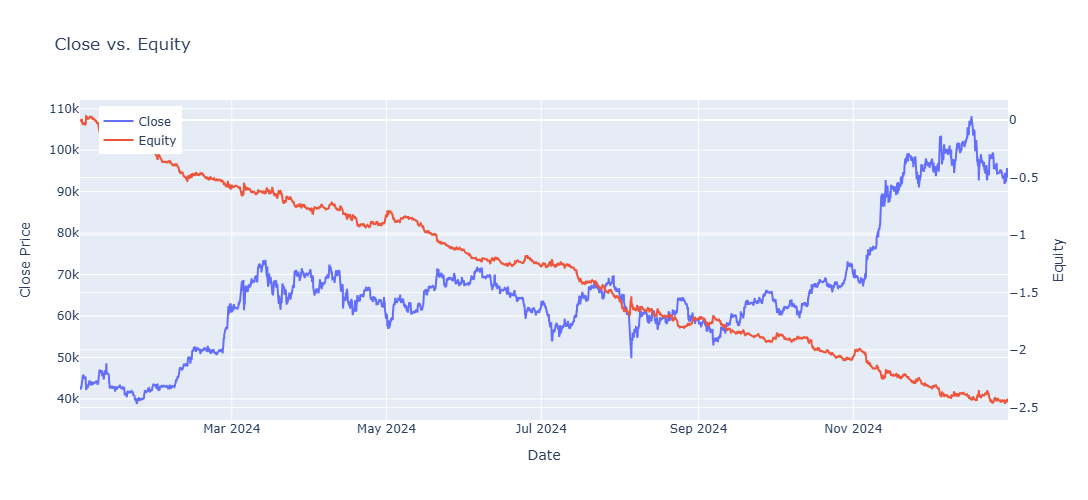

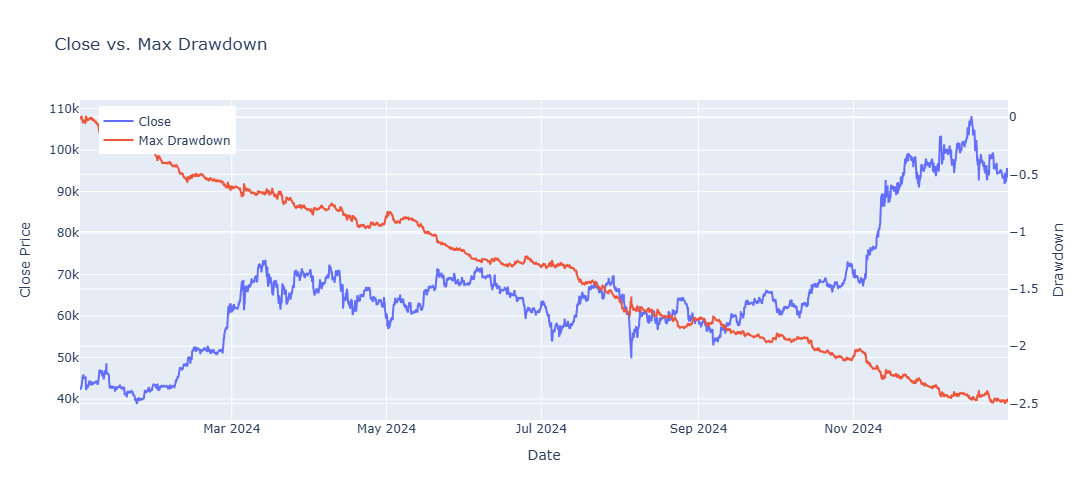

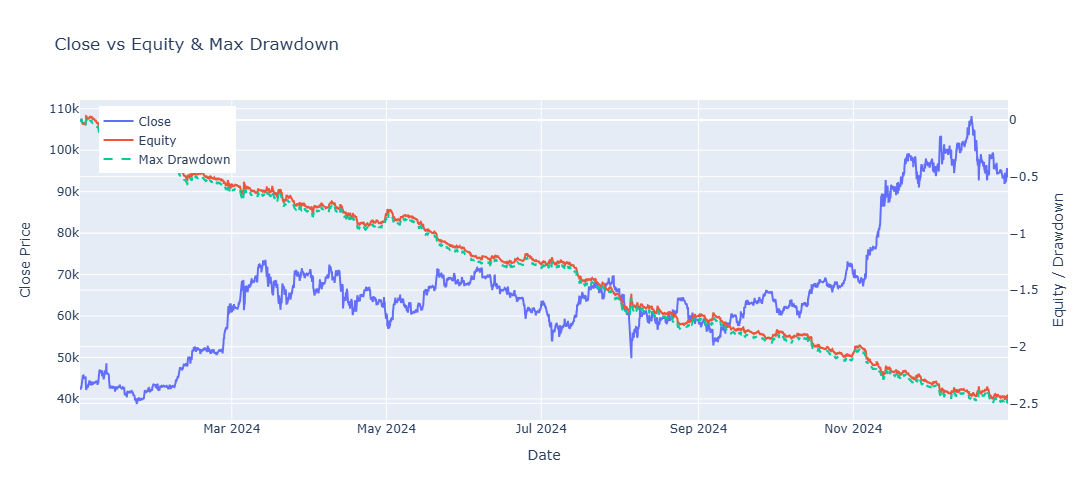

close  positions  trades       pnl    equity    max_dd
datetime                                                                      
2024-01-01 04:00:00  42399.99         -1     1.0 -0.000500 -0.000500  0.000000
2024-01-01 05:00:00  42234.01         -1     0.0  0.003915  0.003415  0.003915
2024-01-01 06:00:00  42396.69         -1     0.0 -0.003852 -0.000437 -0.003852
2024-01-01 07:00:00  42492.46         -1     0.0 -0.002259 -0.002696 -0.006111
2024-01-01 08:00:00  42549.99          1     2.0 -0.002354 -0.005050 -0.008465
2024-01-01 09:00:00  42649.69          1     0.0  0.002343 -0.002707 -0.006122
2024-01-01 10:00:00  42691.10          1     0.0  0.000971 -0.001736 -0.005151
2024-01-01 11:00:00  42690.20          1     0.0 -0.000021 -0.001757 -0.005172
2024-01-01 12:00:00  42648.38          1     0.0 -0.000980 -0.002737 -0.006151
2024-01-01 13:00:00  42715.54          1     0.0  0.001575 -0.001162 -0.004577
2024-01-01 14:00:00  42612.24         -1     2.0 -0.003418 -0.004580 -0.007995
2024-01-01 15:00:00  42783.05          1     2.0 -0.005008 -0.009589 -0.013003
2024-01-01 16:00:00  42725.15          1     0.0 -0.001353 -0.010942 -0.014357
2024-01-01 17:00:00  42812.70          1     0.0  0.002049 -0.008893 -0.012308
2024-01-01 18:00:00  43111.10          1     0.0  0.006970 -0.001923 -0.005338
2024-01-01 19:00:00  43517.99          0     1.0  0.008938  0.007015  0.003601
2024-01-01 20:00:00  43687.86         -1     1.0 -0.000500  0.006515 -0.000500
2024-01-01 21:00:00  43619.21         -1     0.0  0.001571  0.008087  0.001071
2024-01-01 22:00:00  43529.93         -1     0.0  0.002047  0.010133  0.002047
2024-01-01 23:00:00  44179.55         -1     0.0 -0.014924 -0.004790 -0.014924
2024-01-02 00:00:00  45056.00         -1     0.0 -0.019838 -0.024629 -0.034762
2024-01-02 01:00:00  44855.96         -1     0.0  0.004440 -0.020189 -0.030322
2024-01-02 02:00:00  45378.96         -1     0.0 -0.011660 -0.031848 -0.041982
2024-01-02 03:00:00  45402.38         -1     0.0 -0.000516 -0.032364 -0.042498
2024-01-02 04:00:00  45179.80         -1     0.0  0.004902 -0.027462 -0.037595
2024-01-02 05:00:00  45179.48          0     1.0 -0.000493 -0.027955 -0.038088
2024-01-02 06:00:00  45168.75         -1     1.0 -0.000500 -0.028455 -0.038588
2024-01-02 07:00:00  45455.53         -1     0.0 -0.006349 -0.034804 -0.044937
2024-01-02 08:00:00  45759.30         -1     0.0 -0.006683 -0.041487 -0.051620
2024-01-02 09:00:00  45673.48         -1     0.0  0.001875 -0.039611 -0.049745
2024-01-02 10:00:00  45584.99         -1     0.0  0.001937 -0.037674 -0.047807
2024-01-02 11:00:00  45433.99         -1     0.0  0.003312 -0.034361 -0.044495
2024-01-02 12:00:00  45301.99         -1     0.0  0.002905 -0.031456 -0.041589
2024-01-02 13:00:00  45637.93         -1     0.0 -0.007416 -0.038872 -0.049005
2024-01-02 14:00:00  45258.73         -1     0.0  0.008309 -0.030563 -0.040696
2024-01-02 15:00:00  45184.82         -1     0.0  0.001633 -0.028930 -0.039063
2024-01-02 16:00:00  45357.84         -1     0.0 -0.003829 -0.032759 -0.042892
2024-01-02 17:00:00  44966.15         -1     0.0  0.008636 -0.024123 -0.034257
2024-01-02 18:00:00  45154.69         -1     0.0 -0.004193 -0.028316 -0.038450
2024-01-02 19:00:00  45039.49         -1     0.0  0.002551 -0.025765 -0.035898
2024-01-02 20:00:00  44788.28         -1     0.0  0.005578 -0.020187 -0.030321
2024-01-02 21:00:00  45119.74         -1     0.0 -0.007401 -0.027588 -0.037721
2024-01-02 22:00:00  44981.73         -1     0.0  0.003059 -0.024529 -0.034663
2024-01-02 23:00:00  44946.91         -1     0.0  0.000774 -0.023755 -0.033889
2024-01-03 00:00:00  45135.61         -1     0.0 -0.004198 -0.027954 -0.038087
2024-01-03 01:00:00  45317.58          0     1.0 -0.004532 -0.032485 -0.042618
2024-01-03 02:00:00  45274.57          1     1.0 -0.000500 -0.032985 -0.043118
2024-01-03 03:00:00  45262.69          1     0.0 -0.000262 -0.033248 -0.043381
2024-01-03 04:00:00  45183.45          0     1.0 -0.002251 -0.035498 -0.04

In [57]:
EasyPipeline(df, SmartHMMStrategy(model, regime_labels)).run_pipeline().head(50)